In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Model


seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
def Formatting(text):
    text = str(text)
    text=text.lower()
    # Remove numbers 
    text = re.sub(r'\d+','' ,text)
    # Remove new line characters 
    text = re.sub(r'\n',' ',text)
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    #& 
    text = re.sub(r'&;?', 'and',text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
    # Remove characters beyond Readable formart by Unicode:
    text= ''.join(charac for charac in text if charac <= '\uFFFF') 
    text = text.strip()
    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

In [ ]:
# import TextBlob
from textblob import TextBlob

# Forming Dictionary of Images and Captions
images_caption_dict = {}
all_captions = []
images_to_skip = []
images_path = 'C:/Users/kalpe/Documents/Great lakes/ML project/Flickr8k_Dataset/Flicker8k_Dataset/'
with open('Flickr8k.token.txt') as file_tokens:
  for line in file_tokens:
    line = line.strip()
    images = line.split('\t')[0].split('#')[0]
    images = os.path.join(images_path,images)
    caption = line.split('\t')[1]
    if len(caption.split(' ')) < 3 and len(caption.split(' ')) > 26:
      images_to_skip.append(images)
    
    caption = ' '.join([Formatting(x) for x in caption.split(' ')])
    caption = TextBlob(caption)
    caption = caption.correct()
    caption = '<s> '+ str(caption) +' <e>'
    try:
      images_caption_dict[images].append(caption)
    except:
      images_caption_dict[images] = [caption]
      
    all_captions.append(caption)

# Removing Images which have less caption or length less than 3
for image in set(images_to_skip):
  images_caption_dict.pop(images)

In [ ]:
corpus = []
for caption in all_captions:
  corpus.append(caption.split(' '))

In [2]:
import json

# with open('data.json', 'w') as fp:
#     json.dump(images_caption_dict, fp)

with open('data.json', 'r') as openfile:

    json_object = json.load(openfile)

images_caption_dict = dict(json_object)

In [3]:
# print(len(images_caption_dict))
images_path = 'C:/Users/kalpe/Documents/Great lakes/ML project/Flickr8k_Dataset/Flicker8k_Dataset/'
images = list(images_caption_dict.keys())
for image_path in images:
  if image_path.endswith('jpg'):
    new = images_path + image_path.split('/')[-1]
    images_caption_dict[new] = images_caption_dict.pop(image_path)
  else:
    images_caption_dict.pop(image_path)
# print(len(images_caption_dict))

In [4]:
corpus = []
all_captions = []
for item in list(images_caption_dict.values()):
  for caption in item:
    all_captions.append(caption)
    corpus.append(caption.split(' '))

## Custom *Embeddings*

In [5]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors,Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath('C:\\Users\\kalpe\\Documents\\Great lakes\\ML project\\glove.6B.300d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

glove_vectors = KeyedVectors.load_word2vec_format(tmp_file)

<ipython-input-5-ecd9705c5a4e>:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec(glove_file, tmp_file)


In [6]:
# base_model = Word2Vec(size=300)
# base_model.build_vocab(corpus)
# total_examples = base_model.corpus_count

In [7]:
# base_model.build_vocab([list(glove_vectors.vocab.keys())], update=True)

# # train on your data
# base_model.train(corpus, total_examples=total_examples, epochs=10)
# base_model_wv = base_model.wv

In [8]:
# len(base_model_wv.vocab)

## Training and Test Data

In [9]:
#Number of Words
vocabulary_size = 15000
#Max length of  Sentence
max_length_sen = 25

at_tune = tf.data.AUTOTUNE

In [10]:
vectorization = TextVectorization(
    max_tokens= vocabulary_size,
    output_mode="int",
    output_sequence_length=max_length_sen
)

vectorization.adapt(all_captions)

In [11]:
vocab = vectorization.get_vocabulary()
vocab_dictionary = dict()
for i in range(len(vocab)):
    vocab_dictionary[i] = vocab[i]

In [12]:
# len(base_model_wv.word_vec('and'))
embedding_matrix = np.zeros(((vectorization.vocabulary_size()+1), 300))
for i in range(len(vocab)):
  try:
    embedding_vector = glove_vectors.word_vec(vocab[i])
    embedding_matrix[i] = embedding_vector
  except:
    pass

<ipython-input-12-6b8ffeb3f06c>:5: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  embedding_vector = glove_vectors.word_vec(vocab[i])


In [13]:
def train_test_split(dictionary):
  images = dictionary.keys()
  images_test = random.sample(images,int(0.3*len(images)))
  images_train = [img for img in images if img not in images_test]

  train_dict = {
      img: dictionary[img] for img in images_train
  }

  test_dict = {
      img: dictionary[img] for img in images_test
  }
  return(train_dict,test_dict)

train,test = train_test_split(images_caption_dict)

In [14]:
from keras.preprocessing.image import ImageDataGenerator
def resize(img_path, size=(299,299)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img,size=size)
    return img
datagen = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

In [15]:
def train_image_preprocess(x,datagen = datagen):
  img = resize(x)
  img = tf.expand_dims(img, 0)
  img = datagen(img)
  img = img[0]
  img = tf.image.convert_image_dtype(img, tf.float32)
  return(img)

def test_image_preprocess(x):
  img = resize(x)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return(img)

def tf_dataset(images_list,caption_list,flag = None):
  if flag == 'Train':
    img_dataset = tf.data.Dataset.from_tensor_slices(images_list).map(train_image_preprocess,num_parallel_calls=at_tune)

  else:
    img_dataset = tf.data.Dataset.from_tensor_slices(images_list).map(test_image_preprocess,num_parallel_calls= at_tune)
  
  cap_dataset = tf.data.Dataset.from_tensor_slices(caption_list).map(vectorization, num_parallel_calls= at_tune)

  dataset = tf.data.Dataset.zip((img_dataset, cap_dataset))
  dataset = dataset.batch(32).shuffle(256).prefetch(at_tune)
  return(dataset)

train_dataset = tf_dataset(list(train.keys()),list(train.values()),flag ='Train')
test_dataset = tf_dataset(list(test.keys()),list(test.values()))

In [112]:
def cnn_model():
    model = efficientnet.EfficientNetB4(
        input_shape=(299,299, 3), include_top=False, weights="imagenet",
    )
    model.trainable = False
    model_out = model.output
    model_out = layers.Reshape((-1, model_out.shape[-1]))(model_out)
    CNN_model = keras.models.Model(model.input, model_out)
    return CNN_model

### Referenced from https://github.com/Dantekk/Image-Captioning/blob/main/model.py

In [113]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        # print('encinput',inputs)
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)
        # print('encinput_1',inputs)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        # print('encOut',attention_output_1)
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

### Referenced from https://github.com/Dantekk/Image-Captioning/blob/main/model.py

### Intialized the word vectors with Glove Embeddngs

In [114]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim = vocab_size,output_dim = embed_dim,
                                                 weights = [embedding_matrix],input_length=max_length_sen)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs,Position = True):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        if Position == True:
            return embedded_tokens + embedded_positions
        else:
            return embedded_tokens

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

## Extra Attention Layers with Residual Connection

In [115]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        
        self.attention_3 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_4 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)
        
        self.concatenate = layers.Concatenate(axis= 1)
        

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.layernorm_4 = layers.LayerNormalization()
        
        # Intializing GRU's
        self.decoder_gru1 = layers.GRU(embed_dim, name='decoder_gru1',
                       return_sequences=True)
        self.decoder_gru2 = layers.GRU(embed_dim, name='decoder_gru2',
                       return_sequences=True)
        self.decoder_gru3 = layers.GRU(embed_dim, name='decoder_gru3',
                       return_sequences=True)
        
        self.RNN_Trans = layers.Dense(ff_dim,activation = 'relu')
        
        self.flatten_layer = layers.Flatten()
        self.image_hidden_ffn = layers.Dense(embed_dim,
                             activation='tanh',
                             name='decoder_transfer_map')

        self.embedding = PositionalEmbedding(
            embed_dim=300, sequence_length=25, vocab_size= (vectorization.vocabulary_size() + 1)
        )
        self.out = layers.Dense((vectorization.vocabulary_size() + 1), activation="softmax")

        self.dropout_1 = layers.Dropout(0.2)
        self.dropout_2 = layers.Dropout(0.2)
        self.supports_masking = True

    def call(self, cap_inputs, encoder_outputs, image_inputs, training, mask=None):
        # Transformer
        inputs = self.embedding(cap_inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)


        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )

        out_1 = self.layernorm_2(inputs + attention_output_1)
        
        attention_output_2 = self.attention_2(
            query=out_1 ,
            value= out_1,
            key= out_1,
            attention_mask= combined_mask,
            training=training,
        )
        
        
        out_2 = self.layernorm_2(out_1 + attention_output_2)
        
        attention_output_3 = self.attention_3(
            query=out_2,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )

        out_3 = self.layernorm_4(out_2 + attention_output_3)

        attention_output_4 = self.attention_4(
            query= attention_output_3,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        
        #RNN
        image_inputs = self.flatten_layer(image_inputs)
        
        image_hidden_states = self.image_hidden_ffn(image_inputs)

        # Word embeddings
        embedded_tokens = self.embedding(cap_inputs,Position = False)

        # Decoder
        # Connect all the GRU layers.
        net = self.decoder_gru1(embedded_tokens, initial_state=image_hidden_states)
        net = self.decoder_gru2(net, initial_state=image_hidden_states)
        net = self.decoder_gru3(net, initial_state=image_hidden_states)
        net = self.RNN_Trans(net)

        out_4 = self.layernorm_4(out_3 + attention_output_4)
        ffn_out = self.ffn_layer_1(out_4)
        
        ffn_out = self.dropout_1(ffn_out, training=training)
        
        ffn_out = self.ffn_layer_2(ffn_out + net)
        ffn_out = self.layernorm_3(ffn_out + out_4 , training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

### Referenced from https://github.com/Dantekk/Image-Captioning/blob/main/model.py

In [116]:
class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)

        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out,img_embed, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]

In [117]:
cnn_model = cnn_model()
encoder = TransformerEncoderBlock(embed_dim=300, dense_dim = 512, num_heads=3)
decoder = TransformerDecoderBlock(embed_dim= 300, ff_dim= 512, num_heads=3)

# decoder.summary()
capt_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder
)

In [118]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Compile the model
capt_model.compile(optimizer=keras.optimizers.Adam(), loss=cross_entropy)

# Fit the model
history = capt_model.fit(
    train_dataset,
    epochs= 20,
    validation_data=test_dataset,
    callbacks=[early_stopping],
),

Epoch 1/20
177/177 [==============================] - 2985s 16s/step - loss: 18.9778 - acc: 0.2863 - val_loss: 17.0025 - val_acc: 0.3495
Epoch 2/20
177/177 [==============================] - 2876s 16s/step - loss: 16.2061 - acc: 0.3590 - val_loss: 16.1866 - val_acc: 0.3673
Epoch 3/20
177/177 [==============================] - 2947s 16s/step - loss: 15.2284 - acc: 0.3762 - val_loss: 15.8974 - val_acc: 0.3762
Epoch 4/20
177/177 [==============================] - 3095s 17s/step - loss: 14.6060 - acc: 0.3913 - val_loss: 15.7739 - val_acc: 0.3757
Epoch 5/20
177/177 [==============================] - 3109s 17s/step - loss: 14.0442 - acc: 0.4058 - val_loss: 15.6635 - val_acc: 0.3829
Epoch 6/20
177/177 [==============================] - 3109s 17s/step - loss: 13.6130 - acc: 0.4112 - val_loss: 15.6991 - val_acc: 0.3810
Epoch 7/20
177/177 [==============================] - 2915s 16s/step - loss: 13.2240 - acc: 0.4207 - val_loss: 15.6674 - val_acc: 0.3869
Epoch 8/20
177/177 [=====================

In [119]:
len(history[0].history['loss'])

8

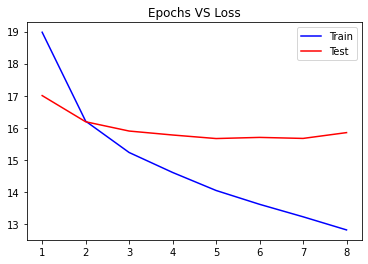

In [120]:
plt.plot(np.arange(0,len(history[0].history['loss']))+1,history[0].history['loss'],'b')
plt.plot(np.arange(0,len(history[0].history['val_loss']))+1,history[0].history['val_loss'],'r')
plt.title("Epochs VS Loss")
plt.legend(['Train','Test'])
# plt.ylim((0,3))
plt.show()

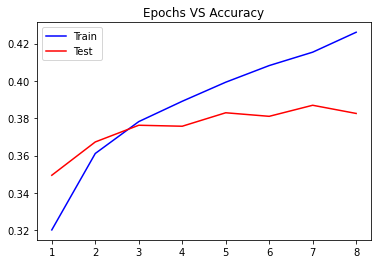

In [121]:
plt.plot(np.arange(0,len(history[0].history['loss']))+1,history[0].history['acc'],'b')
plt.plot(np.arange(0,len(history[0].history['val_loss']))+1,history[0].history['val_acc'],'r')
plt.title("Epochs VS Accuracy")
plt.legend(['Train','Test'])
# plt.ylim((0,3))
plt.show()

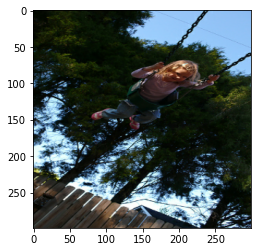

' a boy is jumping on a skateboard'

In [122]:
max_decoded = max_length_sen -1

def generate_caption(img):
    img = test_image_preprocess(img)
    plt.imshow(img.numpy().clip(0, 255).astype(np.uint8))
    plt.show()
    
    # Passing through CNN to get image embeddings
    img = tf.expand_dims(img,0)
    img = capt_model.cnn_model(img)
    
    # Passing through Encoder block
    encoding = capt_model.encoder(img,training = False)
    
    # Intialiazing
    decoded = "<s> "
    for i in range (max_decoded):
        tokens = vectorization([decoded])
#         print(tokens)
        mask = tf.math.not_equal(tokens, 0)
        predictions = capt_model.decoder( tokens,encoding,img,training = False, mask = mask)
        new_word  = np.argmax(predictions[0,i,:])
        new_word = vocab_dictionary[new_word]
        if new_word == 'e':
            break
        else:
            decoded = decoded + ' ' + new_word
        
    decoded = decoded.replace('<s> ','')
    decoded = decoded.replace(' e','')
    return(decoded)

generate_caption(list(test.keys())[60])

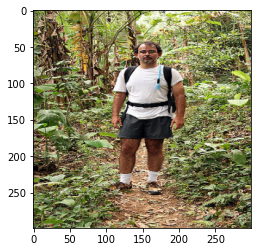

 a man in a red shirt is sitting on a bench and looks at a book


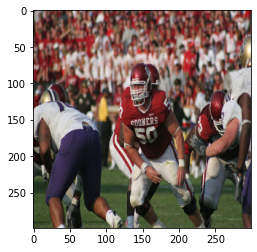

 a man in a red uniform is riding a bike on a camp


 a man in a red uniform is jumping on a camp


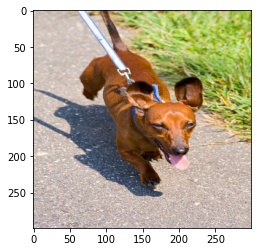

 a brown dog is running through a grassy area


 a group of people are walking on a busy street


 a man in a red uniform is jumping off a camp


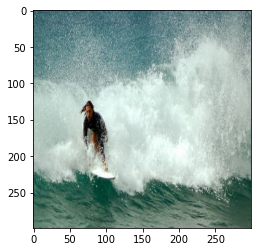

 a suffer is riding a wave


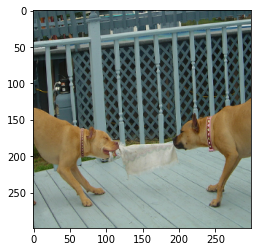

 a brown dog is running through a grassy area


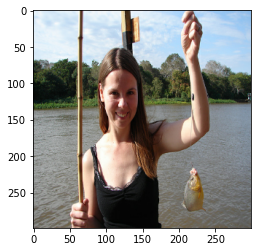

 a man in a white shirt and black parts is sitting on a rock


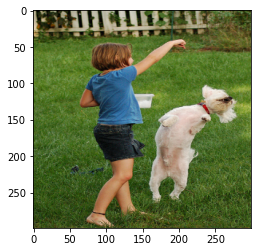

 a dog is running through a tunnel


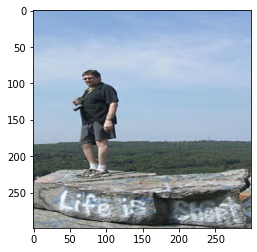

 a man is standing on a rock overlooking a city


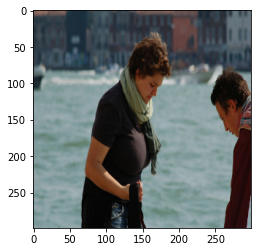

 a man in a blue shirt is standing in the water


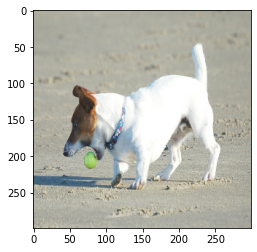

 a white dog is running through a field


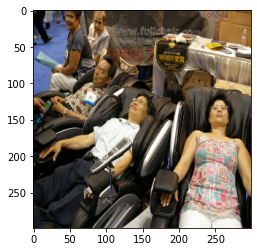

 a man in a red shirt and a woman in a red dress


 a brown dog is running through a grassy area


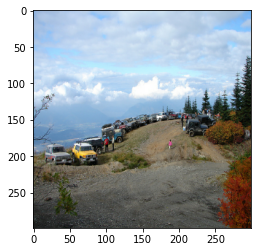

 a man is climbing a rock face


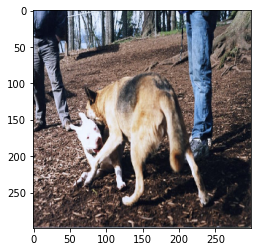

 a man is riding a bike on a camp


 a dog runs through the grass


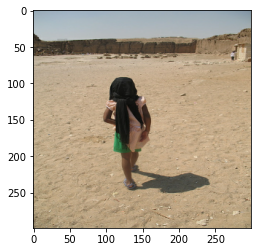

 a man in a red shirt is climbing a rock face


 a man in a red shirt is doing a trick on a skateboard


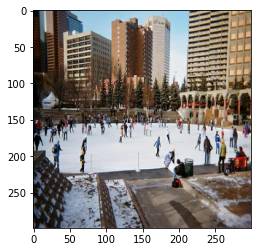

 a man in a red shirt and black parts is jumping on a skateboard


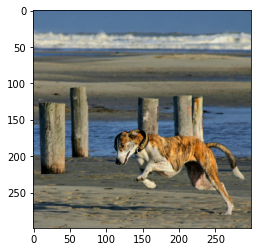

 a dog is running through the grass


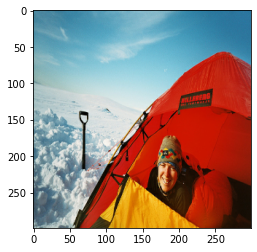

 a man in a red shirt is riding a bicycle on a camp


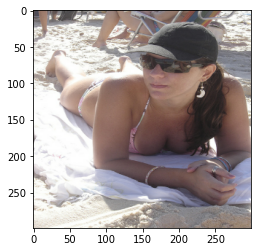

 a boy in a blue shirt is jumping on a surfboard


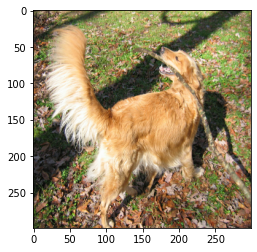

 a brown dog is running through the grass


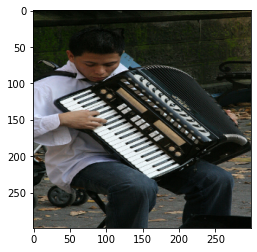

 a man in a red shirt is riding a bike on a camp


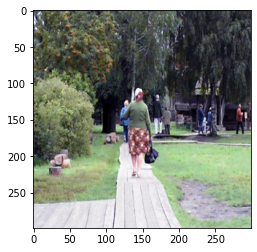

 a man is sitting on a bench and reading a book


 a brown dog is running through the grass


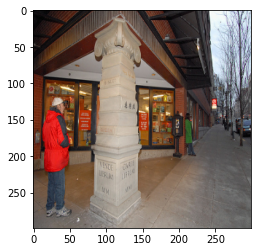

 a man in a red shirt is sitting on a bench with a white umbrella


 a man in a red shirt is climbing a rock face


 a man in a red shirt is climbing a rock face


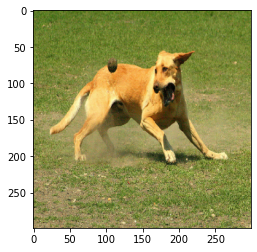

 a dog is running through the grass


 a man in a red uniform is jumping on a camp


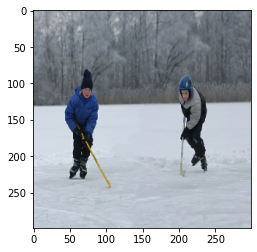

 a man in a red shirt is climbing a rock face


In [123]:
path = 'C:/Users/kalpe/Documents/Great lakes/ML project/Final Test'

iMGES = os.listdir(path)
for img in iMGES:
    print(generate_caption(path + '/' + img))

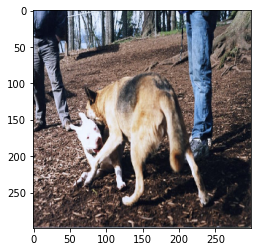

 a man is riding a bike on a camp


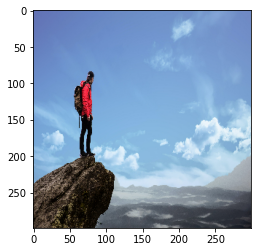

 a man is climbing a rock face


 a dog is running through the grass


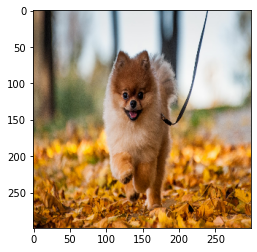

 a brown dog is running through the grass


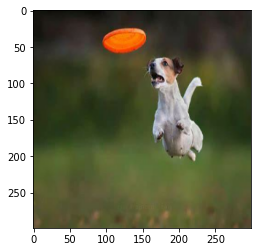

 a dog is running through the grass


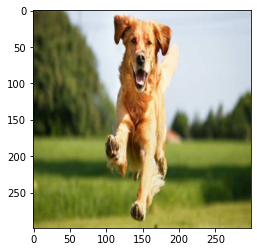

 a dog is running through the grass


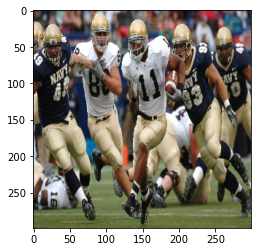

 a man in a red uniform is jumping on a camp


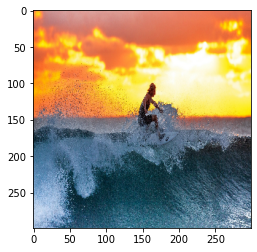

 a man in a blue shirt is riding a bike on a camp


In [124]:
path = 'C:/Users/kalpe/Documents/Great lakes/ML project/Test'

iMGES = os.listdir(path)
for img in iMGES:
    print(generate_caption(path + '/' + img))